In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from source.features_dir import vehicle_data_74t
from source.config import EXTERNAL_DATA_DIR

df = vehicle_data_74t.df_truck_vehicle_data()
column = 'Max vekt'

Q1 = df[column].quantile(0.25)
Q3 = df[column].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]



2025-03-30 14:38:58.688 | INFO     | source.config:<module>:13 - PROJ_ROOT path is: /home/anders/engasjement_svv


# 11: Har 74 t et høyrere miljøutslipp enn dagens lovelig tonnasje.

In [2]:
df['CO₂ (kg)'] = df['CO₂ (tonn)'] * 1000

df_agg = df.groupby('ekvipasje').agg(**{
    'Sum CO₂ (kg)': ('CO₂ (kg)', 'sum'),
    'Sum Distanse (km)': ('Distanse (km)', 'sum'),
}).reset_index()

df_agg['CO₂ snitt (kg/km)'] = df_agg['Sum CO₂ (kg)'] / df_agg['Sum Distanse (km)']

df_agg.round(2)


,ekvipasje,Sum CO₂ (kg),Sum Distanse (km),CO₂ snitt (kg/km)
0,3-akslet trekkvogn med 4-akslet tilhenger,815940.0,605924.0,1.35
1,3-akslet trekkvogn med 5-akslet tilhenger,635300.0,410760.0,1.55
2,4-akslet trekkvogn med 4-akslet tilhenger,612660.0,427178.0,1.43
3,4-akslet trekkvogn med 5-akslet tilhenger,1030520.0,646080.0,1.60


# 44: Bruk av tømmervogntog med økt totalvekt vil redusere CO2-utslipp per transportert kubikkmeter tømmer

# + 45: Bruk av tømmervogntog med høyere totalvekt vil redusere de totale klimagassutslippene per transportert enhet av tømmer.

In [3]:
df_weight = pd.read_csv(EXTERNAL_DATA_DIR / 'bil_henger_basevekt.csv').drop(columns=['ekvipasje'])
df = df.merge(right=df_weight, left_on='VIN', right_on='VIN_lastebil', how='inner')
df['timber (kg)'] = df['Max vekt'] - (df['vekt bil (kg)'] + df['vekt henger (kg)'])
df = df[df['timber (kg)'] > 0]

# Påvirkning på antall turer

In [4]:
df_agg_trips = df.groupby('ekvipasje').agg(**{
    'Tømmer (kg) gjennomsnitt': ('timber (kg)', 'mean'),
    'Tømmer (kg) median': ('timber (kg)', 'median'),
}).reset_index()

reference_mean = df_agg_trips.loc[df_agg_trips['ekvipasje'] == '3-akslet trekkvogn med 4-akslet tilhenger', 'Tømmer (kg) gjennomsnitt'].values[0]
reference_median = df_agg_trips.loc[df_agg_trips['ekvipasje'] == '3-akslet trekkvogn med 4-akslet tilhenger', 'Tømmer (kg) median'].values[0]

df_agg_trips['mean_capacity_factor'] = df_agg_trips['Tømmer (kg) gjennomsnitt'] / reference_mean

df_agg_trips['Gj.snitt forskjell (%)'] = (df_agg_trips['mean_capacity_factor'] - 1) * 100

df_agg_trips['Turreduksjon gj.snitt (%)'] = (1 - 1/df_agg_trips['mean_capacity_factor']) * 100

df_agg_trips = df_agg_trips.drop(['mean_capacity_factor', 'Tømmer (kg) median'], axis=1)

result = df_agg_trips.round(2)

latex_table = result.to_latex(index=False)
print(latex_table)

\begin{tabular}{lrrr}
\toprule
ekvipasje & Tømmer (kg) gjennomsnitt & Gj.snitt forskjell (%) & Turreduksjon gj.snitt (%) \\
\midrule
3-akslet trekkvogn med 4-akslet tilhenger & 46369.980000 & 0.000000 & 0.000000 \\
3-akslet trekkvogn med 5-akslet tilhenger & 43051.230000 & -7.160000 & -7.710000 \\
4-akslet trekkvogn med 4-akslet tilhenger & 47083.490000 & 1.540000 & 1.520000 \\
4-akslet trekkvogn med 5-akslet tilhenger & 51203.690000 & 10.420000 & 9.440000 \\
\bottomrule
\end{tabular}



## Tømmer per tur

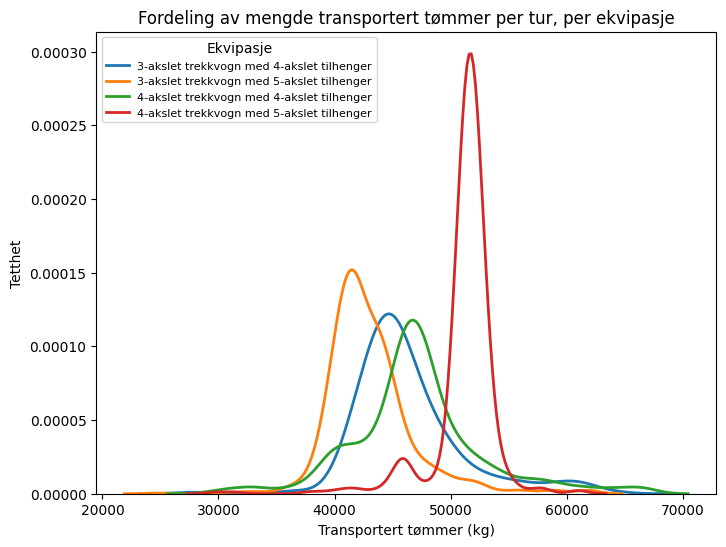

In [5]:
import seaborn as sns

plt.figure(figsize=(8, 6))

for ekvipasje in sorted(df['ekvipasje'].unique()):
    sns.kdeplot(df[df['ekvipasje'] == ekvipasje]['timber (kg)'], label=ekvipasje, linewidth=2)

plt.legend(title="Ekvipasje", fontsize=8)
plt.xlabel("Transportert tømmer (kg)")
plt.ylabel("Tetthet")
plt.title("Fordeling av mengde transportert tømmer per tur, per ekvipasje")
plt.show()

## co2 per tonnkilometer

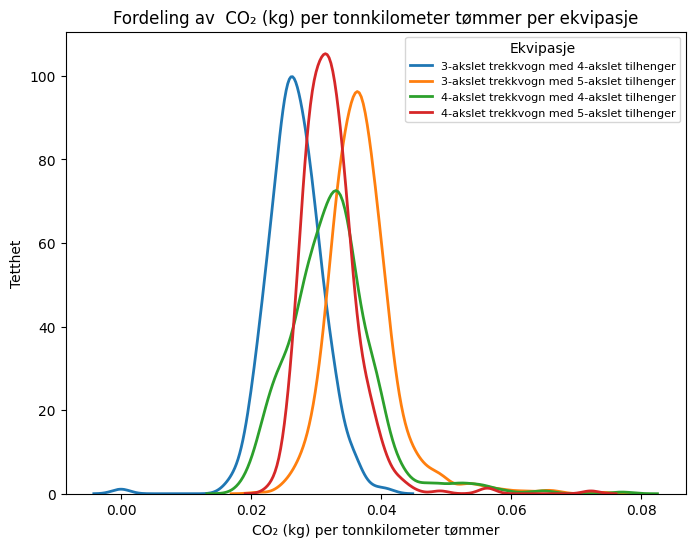

In [6]:
import seaborn as sns

df['CO₂/timber/km'] = df['CO₂ (kg)'] / (df['Distanse (km)'] * (df['timber (kg)'] / 1000))
df_co2_tonkm = df[(0 <= df['CO₂/timber/km']) & (df['CO₂/timber/km'] <= 0.1)]

plt.figure(figsize=(8, 6))
for ekvipasje in sorted(df['ekvipasje'].unique()):
    sns.kdeplot(df_co2_tonkm[df_co2_tonkm['ekvipasje'] == ekvipasje]['CO₂/timber/km'], label=ekvipasje, linewidth=2)

plt.legend(title="Ekvipasje", fontsize=8)
plt.xlabel("CO₂ (kg) per tonnkilometer tømmer")
plt.ylabel("Tetthet")
plt.title("Fordeling av  CO₂ (kg) per tonnkilometer tømmer per ekvipasje")
plt.show()

In [7]:
df_co2_tonkm_agg = df_co2_tonkm.groupby('ekvipasje').agg(**{
    'CO₂ (kg) per tonnkilometer tømmer snitt': ('CO₂/timber/km', 'mean'),
}).reset_index()

reference_mean = df_co2_tonkm_agg.loc[df_co2_tonkm_agg['ekvipasje'] == '3-akslet trekkvogn med 4-akslet tilhenger', 'CO₂ (kg) per tonnkilometer tømmer snitt'].values[0]

df_co2_tonkm_agg['Endring CO₂ gj.snitt (%)'] = 100 * (abs(1 - (df_co2_tonkm_agg['CO₂ (kg) per tonnkilometer tømmer snitt'] / reference_mean)))

result = df_co2_tonkm_agg.round(5)

latex_table = result.to_latex(index=False)
print(latex_table)

\begin{tabular}{lrr}
\toprule
ekvipasje & CO₂ (kg) per tonnkilometer tømmer snitt & Endring CO₂ gj.snitt (%) \\
\midrule
3-akslet trekkvogn med 4-akslet tilhenger & 0.026730 & 0.000000 \\
3-akslet trekkvogn med 5-akslet tilhenger & 0.036990 & 38.369050 \\
4-akslet trekkvogn med 4-akslet tilhenger & 0.032500 & 21.564160 \\
4-akslet trekkvogn med 5-akslet tilhenger & 0.032170 & 20.360140 \\
\bottomrule
\end{tabular}



## Transportert tømmer per (c02/km)

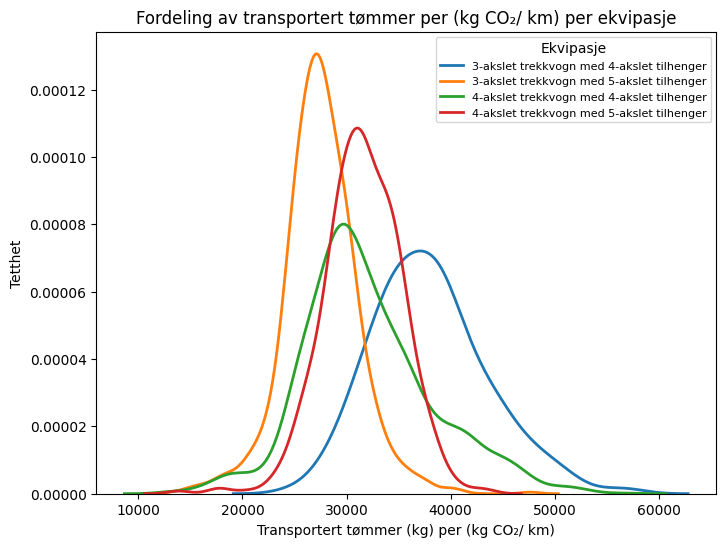

In [8]:
import seaborn as sns

df['timber/CO₂/km'] = df['timber (kg)'] / (df['CO₂ (kg)'] / df['Distanse (km)']) 
df = df[(0 <= df['timber/CO₂/km']) & (df['timber/CO₂/km'] <= 60000)]

plt.figure(figsize=(8, 6))
for ekvipasje in sorted(df['ekvipasje'].unique()):
    sns.kdeplot(df[df['ekvipasje'] == ekvipasje]['timber/CO₂/km'], label=ekvipasje, linewidth=2)

plt.legend(title="Ekvipasje", fontsize=8)
plt.xlabel("Transportert tømmer (kg) per (kg CO₂/ km)")
plt.ylabel("Tetthet")
plt.title("Fordeling av transportert tømmer per (kg CO₂/ km) per ekvipasje")
plt.show()

In [9]:
df_agg2 = df.groupby('ekvipasje').agg(**{
    'Snitt transportert tømmer (kg) per (kg CO₂/ km)': ('timber/CO₂/km', 'mean'),
    'Median transportert tømmer (kg) per (kg CO₂/ km)': ('timber/CO₂/km', 'median'),
}).reset_index()

df_agg2.round(2)

,ekvipasje,Snitt transportert tømmer (kg) per (kg CO₂/ km),Median transportert tømmer (kg) per (kg CO₂/ km)
0,3-akslet trekkvogn med 4-akslet tilhenger,37994.96,37559.38
1,3-akslet trekkvogn med 5-akslet tilhenger,27530.11,27436.90
2,4-akslet trekkvogn med 4-akslet tilhenger,31985.15,30975.00
3,4-akslet trekkvogn med 5-akslet tilhenger,31564.47,31584.14
